# Statistieken SAA

## Introductie

Deze Jupyter notebook produceert statistieken op basis van het al gedigitaliseerde deel van het Amsterdamse Notariële archief (https://archief.amsterdam/inventarissen/details/5075).

Geschreven door:

- Jirsi Reinders [![ORCID](https://info.orcid.org/wp-content/uploads/2020/12/orcid_16x16.gif)](https://orcid.org/0000-0003-2702-4371)
- Leon van Wissen [![ORCID](https://info.orcid.org/wp-content/uploads/2020/12/orcid_16x16.gif)](https://orcid.org/0000-0001-8672-025X)

## Data

- `aktes_per_aktetype.csv`, afkomstig uit RDF-data Golden Agents met SPARQL-query hieronder
- `scans_per_inventarisnummer.csv`, afkomstig uit export 'scope' (intern systeem Stadsarchief Amsterdam)
- `aktes_per_inventarisnummer.csv`, afkomstig uit RDF-data Golden Agents met SPARQL-query hieronder
- `htr_per_inventarisnummer.csv`, afkomstig van ([website Stadsarchief](https://archief.amsterdam/uitleg/handwritten/93-overzicht-beschikbare-htr), versie juli 2023 in CSV formaat)
- `notaris_per_inventarisnummer.csv`, afkomstig uit RDF-data Golden Agents uit het [Notarissennetwerk](https://gitlab.com/uvacreate/vondel/notarissennetwerk-rdf) met SPARQL-query hieronder

### Query's

#### Aktes per aktetype

```sparql
PREFIX rpp: <https://data.goldenagents.org/ontology/rpp/>
SELECT ?akteTypeLabel (COUNT(?deed) AS ?aantal) WHERE {
    ?deed a rpp:IndexDocument ;
          rpp:memberOf <https://data.goldenagents.org/datasets/saa/a2a/08953f2f-309c-baf9-e5b1-0cefe3891b37> ;
          rpp:mentionsEvent ?registrationEvent .

    ?registrationEvent a ?akteType .

    BIND(STRAFTER(STR(?akteType), 'thesaurus/') AS ?akteTypeLabel)

  FILTER(?akteType != rpp:RegistrationEvent)
} GROUP BY ?akteTypeLabel ORDER BY DESC(?aantal)
```

#### Aktes per inventarisnummer (index)

```sparql
PREFIX rpp: <https://data.goldenagents.org/ontology/rpp/>
PREFIX dcterms: <http://purl.org/dc/terms/>
SELECT ?permalink ?inventarisnummer ?temporal (COUNT(DISTINCT ?deed) AS ?index_aantal_aktes) (COUNT(DISTINCT ?scan) AS ?index_aantal_scans) WHERE {
    ?permalink a rpp:BookIndex ;
             dcterms:identifier ?inventarisnummer ;
             rpp:memberOf/rpp:subCollectionOf* <https://archief.amsterdam/inventarissen/file/d5b98b7afa50a3af4fba8053b06fb961> .

    OPTIONAL { ?permalink dcterms:temporal ?temporal . }

    OPTIONAL {
        ?permalink rpp:indexOf ?physicalBook .

        ?physicalDeed rpp:partOf ?physicalBook .

        ?deed rpp:indexOf ?physicalDeed ;
              rpp:onScan ?scan .
    }

} GROUP BY ?permalink ?inventarisnummer ?temporal
```

#### Notarissen (Notarissennetwerk)

```sparql
PREFIX schema: <http://schema.org/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
SELECT ?permalink (SAMPLE(?notarissennetwerkp) AS ?notarissennetwerk) (SAMPLE(?notarisn) AS ?notaris) WHERE {
  {
    ?permalink schema:author ?notarisid .

    ?notarisid schema:name ?notarisn .

    ?notarissennetwerkp schema:mainEntity ?notarisid .

  }
} GROUP BY ?permalink
```


In [1]:
import pandas as pd
import numpy as np

## Statistieken

Ter inleiding, een overzicht van het soort aktes in het Notarieel Archief:


In [2]:
df_aktes = pd.read_csv("aktes_per_aktetype.csv")
df_aktes.set_index("akteTypeLabel", inplace=True)
df_aktes

,aantal
akteTypeLabel,
Machtiging,150596
Wisselprotest,122216
Testament,72023
Transport,66913
Attestatie,65241
Kwitantie,36686
Insinuatie,24947
Scheepsverklaring,22609
Obligatie,20300


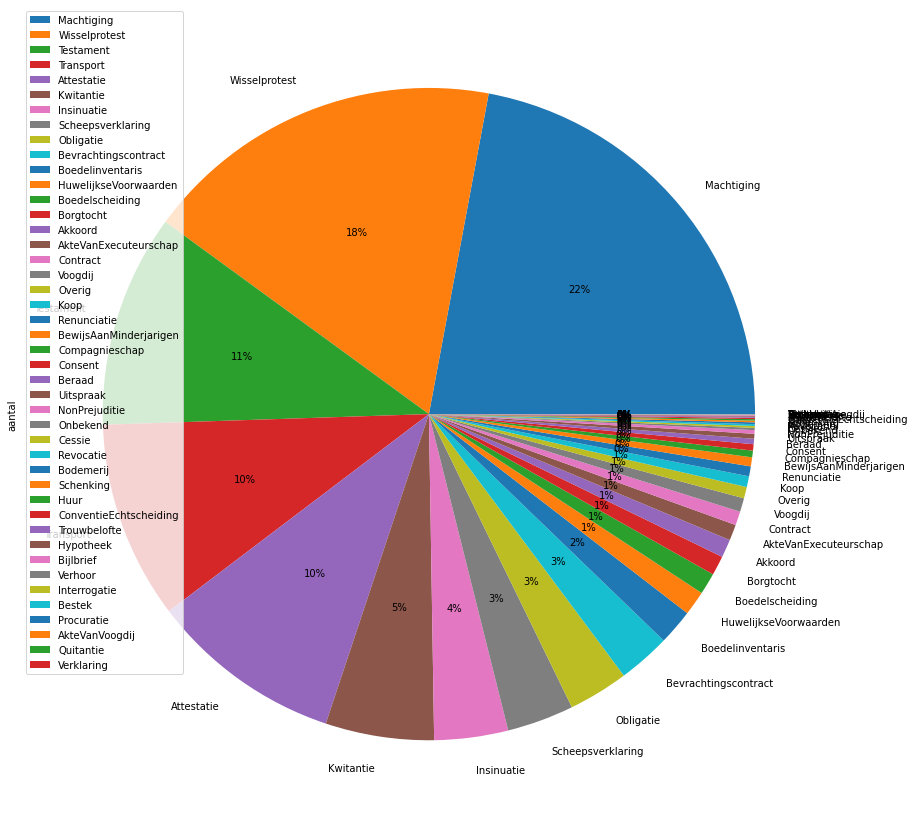

In [3]:
ax = df_aktes.plot.pie(y="aantal", figsize=(15, 15), autopct="%1.0f%%")

Verder op het scanniveau:


In [4]:
df_scans = pd.read_csv("scans_per_inventarisnummer.csv")
df_aktes = pd.read_csv("aktes_per_inventarisnummer.csv")
df_htr = pd.read_csv("htr_per_inventarisnummer.csv")
df_notaris = pd.read_csv("notaris_per_inventarisnummer.csv")

Die bestanden moeten samengevoegd worden. De kolom `inventarisnummer` bevat hier waardes die in de vier bestanden voorkomen.


In [5]:
df_scans_aktes = pd.merge(
    df_scans,
    df_aktes,
    how="outer",
    on="inventarisnummer",
)
df_scans_aktes_htr = pd.merge(
    df_scans_aktes, df_htr, how="outer", on="inventarisnummer"
)
df_scans_aktes_htr_notaris = pd.merge(
    df_scans_aktes_htr, df_notaris, how="outer", on="permalink"
)

De samenvoeging kunnen we opslaan in één bestand:


In [6]:
df_scans_aktes_htr_notaris.to_csv("df_scans_aktes_htr_notaris.csv", index=False)

We kunnen alleen wat doen bij inventarisnummers waarvoor we een soort van datum hebben. De rest laten we vallen. Daarna plukken we een start- en einddatum uit de informatie voor elk inventarisnummer.


In [7]:
df_scans_aktes_htr_notaris.dropna(subset=["temporal"], inplace=True)

In [8]:
# Replace all the 0's by NaN
df_scans_aktes_htr_notaris.replace(0, np.NaN, inplace=True)

In [9]:
df_scans_aktes_htr_notaris["date_start"] = [
    i.split("/")[0] for i in df_scans_aktes_htr_notaris["temporal"]
]
df_scans_aktes_htr_notaris["date_end"] = [
    i.split("/")[1] for i in df_scans_aktes_htr_notaris["temporal"]
]

# Trick to have dates as periods before 1677-09-22
df_scans_aktes_htr_notaris["date_start"] = df_scans_aktes_htr_notaris[
    "date_start"
].apply(lambda x: pd.Period(x))
df_scans_aktes_htr_notaris["date_end"] = df_scans_aktes_htr_notaris["date_end"].apply(
    lambda x: pd.Period(x)
)

df_scans_aktes_htr_notaris["year_start"] = df_scans_aktes_htr_notaris[
    "date_start"
].apply(lambda x: pd.Period(x).year)
df_scans_aktes_htr_notaris["year_end"] = df_scans_aktes_htr_notaris["date_end"].apply(
    lambda x: pd.Period(x).year
)

# df_scans_aktes_htr_notaris['year_start'] = pd.to_datetime(df_scans_aktes_htr_notaris['year_start'])
# df_scans_aktes_htr_notaris['year_end'] = pd.to_datetime(df_scans_aktes_htr_notaris['year_end'])

Deze nieuwe DataFrame bevat nu twee kolommen `year_start` en `year_end` waarmee we straks kunnen rekenen.


In [10]:
df_scans_aktes_htr_notaris

,scopeid,inventarisnummer,aantal_scans,permalink,temporal,index_aantal_aktes,index_aantal_scans,rubriek,htr_notaris,serienummer,htr_titel,htr_aantal_scans,htr_status,notarissennetwerk,notaris,date_start,date_end,year_start,year_end
0,313844.0,1A,41.0,https://archief.amsterdam/inventarissen/file/6...,1578-01-01/1579-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/2038,Jan Jansz. Pilorius,1578-01-01,1579-12-31,1578,1579
1,313845.0,1B,61.0,https://archief.amsterdam/inventarissen/file/7...,1579-01-01/1580-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/2038,Jan Jansz. Pilorius,1579-01-01,1580-12-31,1579,1580
2,313846.0,1C,44.0,https://archief.amsterdam/inventarissen/file/6...,1580-01-01/1580-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/2038,Jan Jansz. Pilorius,1580-01-01,1580-12-31,1580,1580
3,313847.0,1D,10.0,https://archief.amsterdam/inventarissen/file/8...,1580-01-01/1580-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/2038,Jan Jansz. Pilorius,1580-01-01,1580-12-31,1580,1580
4,313848.0,1E,33.0,https://archief.amsterdam/inventarissen/file/1...,1581-01-01/1581-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/2038,Jan Jansz. Pilorius,1581-01-01,1581-12-31,1581,1581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32553,NaN,7971,NaN,https://archief.amsterdam/inventarissen/file/d...,1716-01-01/1716-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/1941,Philippe de Marolles,1716-01-01,1716-12-31,1716,1716
32554,NaN,7968,NaN,https://archief.amsterdam/inventarissen/file/e...,1715-01-01/1715-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/1941,Philippe de Marolles,1715-01-01,1715-12-31,1715,1715
32555,NaN,7967,NaN,https://archief.amsterdam/inventarissen/file/f...,1715-01-01/1715-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/1941,Philippe de Marolles,1715-01-01,1715-12-31,1715,1715
32556,NaN,18817,NaN,https://archief.amsterdam/inventarissen/file/8...,1813-01-01/1814-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/1857,Ludovicus Albertus Holtz,1813-01-01,1814-12-31,1813,1814


We willen voor ongescande inventarisnummers ook een schatting kunnen maken van het aantal potentiële scans. Dit geeft ons inzicht op hoeveel ongescand materiaal er per jaar nog beschikbaar is. Allereerst vullen we inventarisnummers zonder scans in op basis van het gemiddelde van de notaris. Als dit niet mogelijk is, dan vullen we dit met het gemiddelde van dat jaar.


In [11]:
# Per 'group' [= a notary] fill the missing values with the mean of the notary
df_scans_aktes_htr_notaris["schatting_aantal_scans"] = (
    df_scans_aktes_htr_notaris[["aantal_scans", "notarissennetwerk"]]
    .groupby("notarissennetwerk")
    .transform(lambda x: x.fillna(x.mean()))
)

# For the other NaN values, per 'group' [= a year] fill the missing values with the mean of the year
df_scans_aktes_htr_notaris["schatting_aantal_scans"] = (
    df_scans_aktes_htr_notaris[["schatting_aantal_scans", "year_start"]]
    .groupby("year_start")
    .transform(lambda x: x.fillna(x.mean()))
)

Opnieuw slaan we het tussentijdse bestand op.


In [12]:
df_scans_aktes_htr_notaris.to_csv("df_schatting_scans_aktes_htr_notaris.csv")

## Visualisaties

Een aantal kolommen hebben we niet nodig. We gebruiken voor onderstaande ook enkel de `year_start` als datum voor een inventarisnummer.


In [13]:
df = df_scans_aktes_htr_notaris.drop(
    ["scopeid", "rubriek", "year_end", "index_aantal_aktes"], axis=1
)

In [14]:
df

,inventarisnummer,aantal_scans,permalink,temporal,index_aantal_scans,htr_notaris,serienummer,htr_titel,htr_aantal_scans,htr_status,notarissennetwerk,notaris,date_start,date_end,year_start,schatting_aantal_scans
0,1A,41.0,https://archief.amsterdam/inventarissen/file/6...,1578-01-01/1579-12-31,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/2038,Jan Jansz. Pilorius,1578-01-01,1579-12-31,1578,41.000000
1,1B,61.0,https://archief.amsterdam/inventarissen/file/7...,1579-01-01/1580-12-31,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/2038,Jan Jansz. Pilorius,1579-01-01,1580-12-31,1579,61.000000
2,1C,44.0,https://archief.amsterdam/inventarissen/file/6...,1580-01-01/1580-12-31,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/2038,Jan Jansz. Pilorius,1580-01-01,1580-12-31,1580,44.000000
3,1D,10.0,https://archief.amsterdam/inventarissen/file/8...,1580-01-01/1580-12-31,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/2038,Jan Jansz. Pilorius,1580-01-01,1580-12-31,1580,10.000000
4,1E,33.0,https://archief.amsterdam/inventarissen/file/1...,1581-01-01/1581-12-31,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/2038,Jan Jansz. Pilorius,1581-01-01,1581-12-31,1581,33.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32553,7971,NaN,https://archief.amsterdam/inventarissen/file/d...,1716-01-01/1716-12-31,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/1941,Philippe de Marolles,1716-01-01,1716-12-31,1716,547.783784
32554,7968,NaN,https://archief.amsterdam/inventarissen/file/e...,1715-01-01/1715-12-31,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/1941,Philippe de Marolles,1715-01-01,1715-12-31,1715,547.783784
32555,7967,NaN,https://archief.amsterdam/inventarissen/file/f...,1715-01-01/1715-12-31,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/1941,Philippe de Marolles,1715-01-01,1715-12-31,1715,547.783784
32556,18817,NaN,https://archief.amsterdam/inventarissen/file/8...,1813-01-01/1814-12-31,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/1857,Ludovicus Albertus Holtz,1813-01-01,1814-12-31,1813,616.664306


Een eerste visualisatie is op basis van de som van alle scans (schatting, beschikbaar, geïndexeerd en geHTRd).

Twee visualisaties:

- De aantallen als punten
- De aantallen als punten t/m 1811


In [15]:
df_year_sum = df.groupby("year_start").sum(numeric_only=True)
df_year_sum.replace(0, np.NaN, inplace=True)  # The sum of NaN's is 0
df_year_sum

,aantal_scans,index_aantal_scans,htr_aantal_scans,schatting_aantal_scans
year_start,,,,
1578,41.0,NaN,NaN,41.000000
1579,61.0,NaN,NaN,372.000000
1580,54.0,NaN,NaN,54.000000
1581,78.0,NaN,NaN,173.318182
1582,78.0,NaN,NaN,78.000000
...,...,...,...,...
1914,1660.0,NaN,NaN,47835.593570
1915,1478.0,NaN,NaN,47111.555660
1925,470.0,NaN,NaN,1286.000000


Text(0, 0.5, 'aantal')

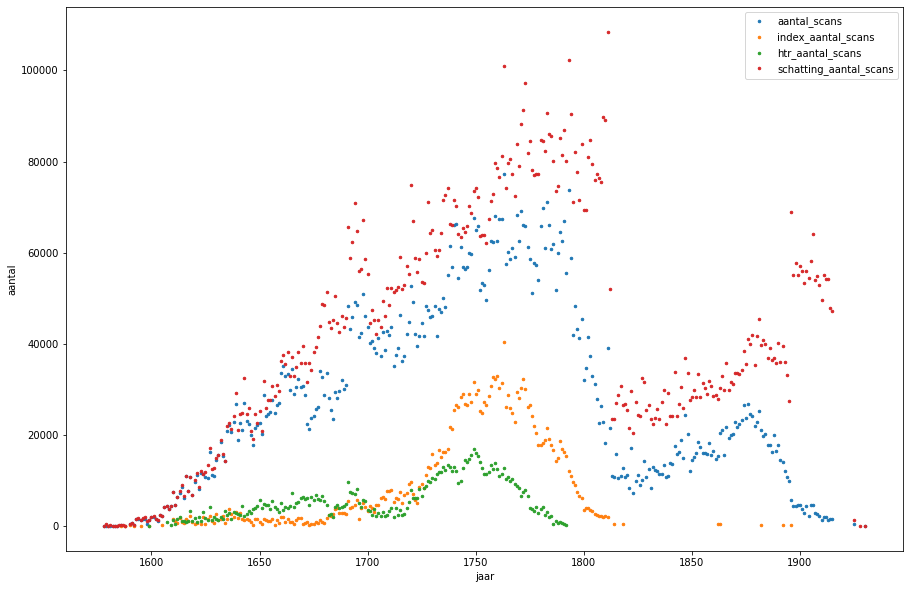

In [16]:
ax = df_year_sum.plot(figsize=(15, 10), linestyle="None", marker=".", markersize=5)
ax.set_xlabel("jaar")
ax.set_ylabel("aantal")

Text(0, 0.5, 'aantal')

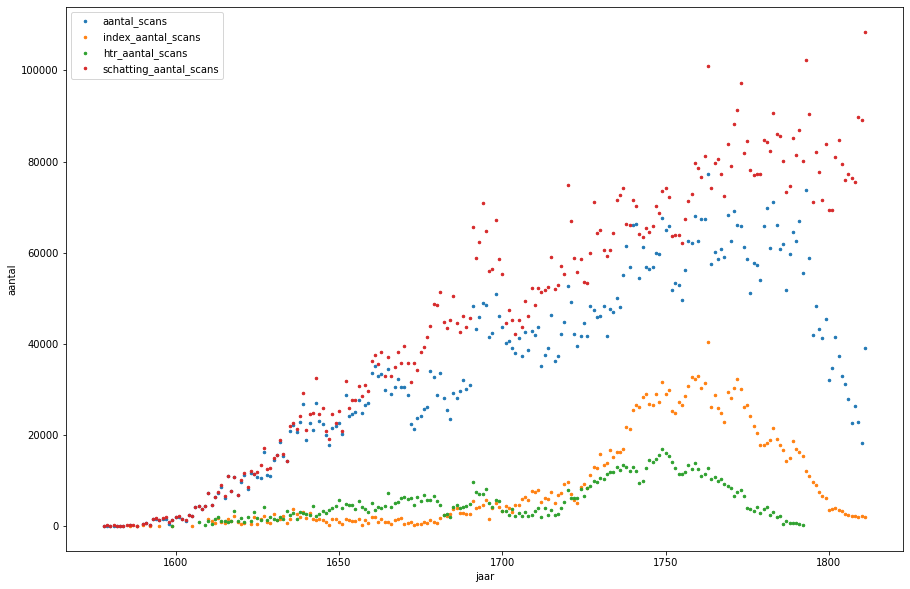

In [17]:
# Only <= 1811
ax = df_year_sum[df_year_sum.index <= 1811].plot(
    figsize=(15, 10), linestyle="None", marker=".", markersize=5
)
ax.set_xlabel("jaar")
ax.set_ylabel("aantal")

Een andere manier om dit te visualiseren (en om duidelijk te maken hoe de scans, index, en HTR elkaar aanvullen) is in een gestapelde grafiek.

Eerst moeten we zicht krijgen op:

- Het aantal ongerealiseerde scans
- Het aantal scans waarmee niets gebeurd is
- Het aantal scans dat alleen geïndexeerd is
- Het aantal scans dat alleen geHTRd is
- Het aantal scans dat zowel geïndexeerd als geHTRd is


In [18]:
# For the minimum function, we need the 0s back
df.replace(np.NaN, 0, inplace=True)

In [19]:
df["scan + htr + index"] = df[["index_aantal_scans", "htr_aantal_scans"]].min(
    axis=1
)  # minimum van beide
df["scan + htr"] = (df["htr_aantal_scans"] - df["index_aantal_scans"]).clip(
    lower=0
)  # htr minus index
df["scan + index"] = (df["index_aantal_scans"] - df["htr_aantal_scans"]).clip(
    lower=0
)  # index minus htr
df["scan"] = (
    df["aantal_scans"] - df["index_aantal_scans"] - df["htr_aantal_scans"]
).clip(
    lower=0
)  # geen index/htr
df["ongescand"] = (df["schatting_aantal_scans"] - df["aantal_scans"]).clip(
    lower=0
)  # schatting minus scan

Deze aantallen kunnen we stapelen per jaar:


In [20]:
df_stats = df[
    [
        "scan + htr + index",
        "scan + htr",
        "scan + index",
        "scan",
        "ongescand",
        "year_start",
    ]
]

df_stats_year = df_stats.groupby("year_start").sum()
df_stats_year.replace(0, np.NaN, inplace=True)  # The sum of NaN's is 0

Text(0, 0.5, 'aantal')

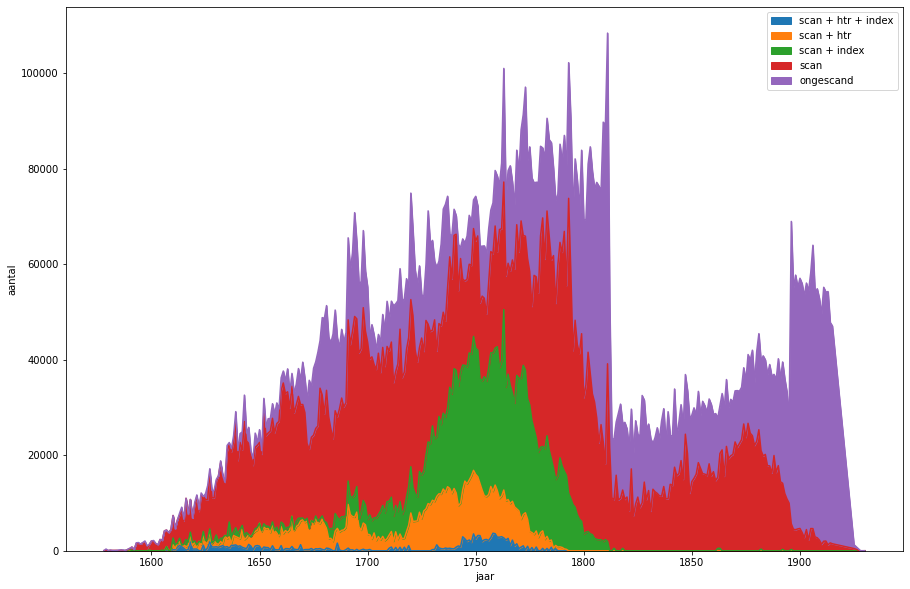

In [21]:
ax = df_stats_year.plot.area(figsize=(15, 10))
ax.set_xlabel("jaar")
ax.set_ylabel("aantal")

Text(0, 0.5, 'aantal')

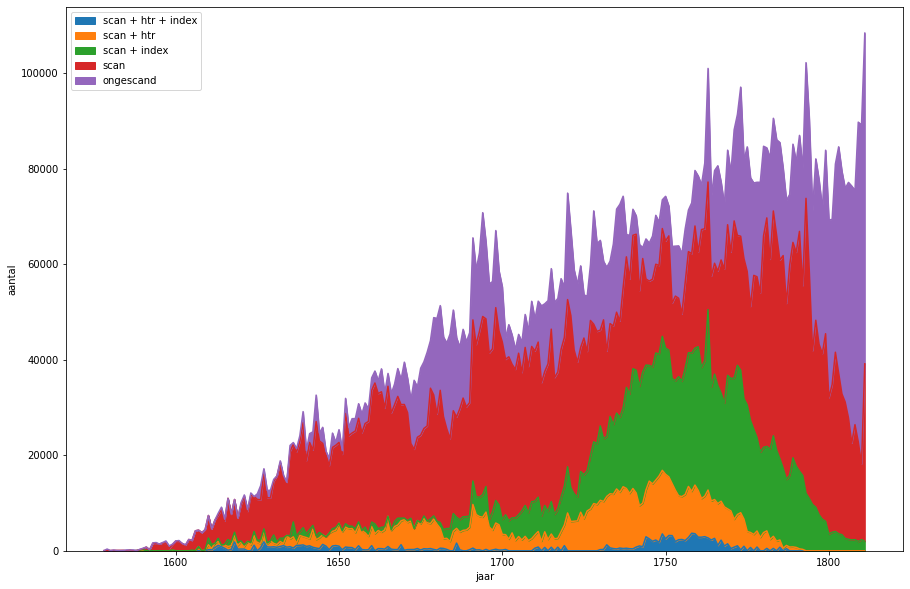

In [22]:
ax = df_stats_year[df_stats_year.index <= 1811].plot.area(figsize=(15, 10))
ax.set_xlabel("jaar")
ax.set_ylabel("aantal")